In [2]:
# path operations
from glob import glob
import os
from pathlib import Path

# data format and storage
from collections import namedtuple
import pickle

# numerical tools
import numpy as np
import scipy.stats
import pandas as pd

# plotting tools
from matplotlib import pyplot as plt
# %matplotlib notebook

# interactive notebook features
from tqdm import tqdm_notebook as tqdm
from ipywidgets import interact

# meg analysis
import mne

## Find all available subjects

Define where you store your `camcan` data in the variable `camcanroot`.

In [9]:
# camcanroot = Path('/Volumes') / 'Seagate Expansion Drive' /'camcan'
# camcanroot = Path('D:') / 'camcan'
# camcanroot = Path('/data') / 'group' / 'FANS' / 'camcan-meg' / 'camcan165' / 'camcan165'
camcanroot = Path('/Users') / 'jan' / 'Documents' / 'eeg-data' / 'camcan'

megdataroot = camcanroot / 'cc700' / 'mri' / 'pipeline' / 'release004' / 'BIDSsep' / 'megraw'
subjects = list(megdataroot.glob('sub-*'))
ids = [os.path.split(subject)[-1][4:] for subject in subjects]

print(f'{len(subjects)} subjects found in {megdataroot}')

restfiles = list(megdataroot.glob(pattern='*/meg/rest_raw.fif'))
taskfiles = list(megdataroot.glob(pattern='*/meg/task_raw.fif'))

# filter out no-files
print(f'{len(restfiles)} subjects have resting-state recordings.')
print(f'{len(taskfiles)} subjects have task recordings.')

# find the demographic info
subject_details = pd.DataFrame.from_csv(camcanroot / 'cc700-scored' / 'participant_data.csv')
print(f'Found subject information on {len([pid for pid in ids if pid in subject_details.index])} subjects.')

2 subjects found in /Users/jan/Documents/eeg-data/camcan/cc700/mri/pipeline/release004/BIDSsep/megraw
2 subjects have resting-state recordings.
2 subjects have task recordings.
Found subject information on 2 subjects.


## Set up MEG analysis variables

In [10]:
veog = 'EOG062'
heog = 'EOG061'
ecg = 'ECG063'
recording='task'
fmin, fmax = 2, 24

## Loop over MEG data

First, make a data structure we can put the data in

In [11]:
sub_params = namedtuple('sub_params',
                        ['pid', 'slopes', 'age', 'gender',
                         'intercepts', 'rsquared'])

For the pre-processing, we'll also use Maxwell-filtering to correct for extraneous influence. These are the necessary files:

In [12]:
ctfile = megdataroot / 'ct_sparse.fif'
ssscal = megdataroot / 'sss_cal.dat'

Then, populate this data structure for each subject

In [40]:
raw = mne.io.read_raw_fif(taskfiles[1], verbose='WARNING')
raw = raw.crop(tmin=20, tmax=500)

no_eog_raws = [raw.copy().crop(tmin=tmin, tmax=tmin+2)
               for tmin in np.arange(0, 480, step=2)
               if not np.any((eog_timepoints > tmin*raw.info['sfreq']) &
                             (eog_timepoints < (tmin+2)*raw.info['sfreq']))]

no_eog_raw = mne.concatenate_raws(no_eog_raws)
# raw = raw.load_data()
# raw = raw.resample(256)


In [38]:
raw = mne.concatenate_raws(no_eog_raws)

tmax defaults to 60. in 0.14 but will change to np.inf in 0.15. Set it explicitly to avoid this warning


<ipython-input-42-cc79440c7f53>:1: DeprecationWarning: tmax defaults to 60. in 0.14 but will change to np.inf in 0.15. Set it explicitly to avoid this warning
  raw.plot_psd(fmin=0, fmax=45);
/Library/anaconda/envs/py36/lib/python3.6/site-packages/mne/viz/raw.py:614: DeprecationWarning: In version 0.15 average will default to False and spatial_colors will default to True.
  'spatial_colors will default to True.', DeprecationWarning)


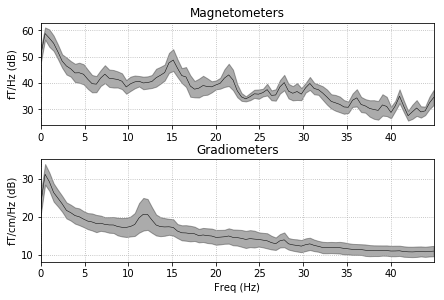

tmax defaults to 60. in 0.14 but will change to np.inf in 0.15. Set it explicitly to avoid this warning


<ipython-input-42-cc79440c7f53>:2: DeprecationWarning: tmax defaults to 60. in 0.14 but will change to np.inf in 0.15. Set it explicitly to avoid this warning
  no_eog_raw.plot_psd(fmin=0, fmax=45);
/Library/anaconda/envs/py36/lib/python3.6/site-packages/mne/viz/raw.py:614: DeprecationWarning: In version 0.15 average will default to False and spatial_colors will default to True.
  'spatial_colors will default to True.', DeprecationWarning)


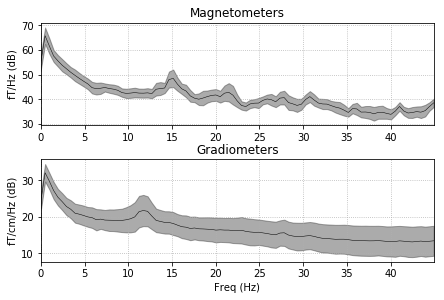

In [42]:
raw.plot_psd(fmin=0, fmax=45);
no_eog_raw.plot_psd(fmin=0, fmax=45);

In [32]:


np.sum([1 for tmin in np.arange(0, 480, step=2)
        if not np.any((eog_timepoints > tmin*raw.info['sfreq']) &
                      (eog_timepoints < (tmin+2)*raw.info['sfreq']))])

np.sum([1 for tmin in np.arange(0, 480, step=2)
        ])


240

In [23]:
eog_timepoints = eog_events[:, 0]


no_eog_raws = [r.crop() for tstart]


array([ 21009,  21068,  25040,  25413,  25555,  25707,  25830,  29481,
        29678,  29856,  33811,  34418,  36052,  44433,  45536,  48634,
        51907,  52925,  53134,  53281,  54483,  55265,  55446,  56568,
        57773,  57897,  57964,  58406,  58488,  58709,  60535,  64565,
        65781,  65944,  66126,  66342,  66587,  66968,  67356,  67635,
        67922,  68159,  69109,  69178,  69385,  69632,  69841,  70820,
        71091,  71624,  72636,  72830,  72966,  73061,  73509,  73608,
        74106,  74256,  74456,  74570,  75545,  75677,  75830,  76096,
        76863,  79109,  79254,  80863,  80969,  82503,  83514,  85736,
        97687,  97831,  98969, 101666, 101846, 102006, 102107, 102267,
       102335, 102500, 103303, 103981, 107643, 108134, 109847, 109926,
       110103, 111237, 112635, 113000, 113079, 113164, 115636, 115822,
       123132, 123208, 125404, 125745, 126014, 126235, 127669, 128128,
       128565, 128764, 128876, 129282, 130398, 130995, 131412, 132592,
      

Using channel EOG062 as EOG channel
EOG channel index for this subject is: [321]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Setting up band-pass filter from 2 - 45 Hz
Setting up band-pass filter from 1 - 10 Hz
Now detecting blinks and generating corresponding events
Number of EOG events detected : 121
121 matching events found
8 projection items activated
Loading data for 121 events and 513 original time points ...
0 bad epochs dropped


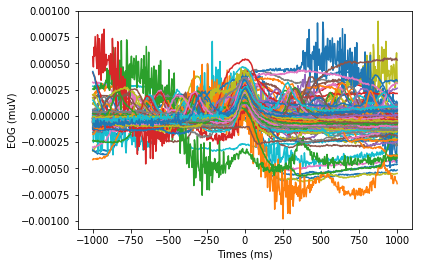

In [21]:
eog_events = mne.preprocessing.find_eog_events(raw, 998, ch_name=veog)

tmin, tmax = -1, 1
epochs = mne.Epochs(raw, eog_events, 998, tmin, tmax,
                    picks=mne.pick_types(raw.info, meg=False, eog=True))
data = epochs.get_data()

plt.plot(1e3 * epochs.times, np.squeeze(data[:, 1, :]).T)
plt.xlabel('Times (ms)')
plt.ylabel('EOG (muV)')
plt.show()

In [ ]:
all_parameters = []
psds = []

for subject in tqdm(range(2)):
    # resting state file
    restfile = subjects[subject] / 'meg' / (recording + '_raw.fif')
    # raw data
    raw = mne.io.read_raw_fif(restfile, verbose='WARNING')
    # crop
    raw = raw.crop(tmin=20, tmax=500)
    # resample
    raw = raw.load_data()
    raw = raw.resample(256)
    # filter
    # filter the MEG data (exclude line noise)
    raw = raw.filter(0.5, 30, picks=mne.pick_types(raw.info, meg=True))
    # filter the EOG data
    raw = raw.filter(0.5, 15, picks=mne.pick_types(raw.info, meg=False, eog=True))
    # filter the ECG data
    raw = raw.filter(0.5, 15, picks=mne.pick_types(raw.info, meg=False, ecg=True))
    # maxwell-correction
    raw = mne.preprocessing.maxwell_filter(raw, cross_talk=str(ctfile), calibration=str(ssscal),
                                           st_duration=10, st_correlation=0.98)
    # pick gradiometers
    picks = mne.pick_types(raw.info, meg='grad', eeg=False, stim=False, eog=False, exclude='bads')
    # run an ICA
    try:
        ica = mne.preprocessing.run_ica(raw, n_components=0.95,
                                        picks=picks,
                                        eog_ch=veog, ecg_ch=ecg)
        raw = ica.apply(raw, exclude=ica.exclude)
    except RuntimeError:
        continue
    
    
    # do the PSD analysis
    psd, freqs = mne.time_frequency.psd_welch(
        raw, picks=picks, fmin=fmin, fmax=fmax, n_fft=2000, n_overlap=1000,
        verbose='WARNING', n_jobs=4
    )

    # Do the linear regression
    findices = (freqs < 7) | (freqs > 14)
    linfits = [scipy.stats.linregress(freqs[findices], np.log10(psd.T[findices, grad]))
               for grad in range(psd.shape[0])]

    psds.append(psd)
    all_parameters.append(
        sub_params(pid=ids[subject],
                   slopes=np.array([l.slope for l in linfits]),
                   intercepts=np.array([l.intercept for l in linfits]),
                   rsquared=np.array([l.rvalue**2 for l in linfits]),
                   age=subject_details.loc[ids[subject]].age,
                   gender=subject_details.loc[ids[subject]].gender_code)
    )
    with open(Path('.') / 'pickles' / (ids[subject] + '-' + recording + '.pickle'), 'wb+') as f:
        pickle.dump((psd, sub_params), f)



### Save data to pickles

In [ ]:
# save data to file
with open(Path('.')/'pickles'/('psds-'+recording+'.pickle'), 'wb+') as f:
    pickle.dump(psds, f)
with open(Path('.')/'pickles'/('all_parameters-'+recording+'.pickle'), 'wb+') as f:
    pickle.dump(all_parameters, f)
